In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
#한글깨짐방지
plt.rc('font',family='Malgun Gothic')
plt.rcParams['axes.unicode_minus'] = False

In [4]:
path = './data/'
train = pd.read_csv(path +'201901-202003.csv')
submission = pd.read_csv(path + 'submission.csv')

### EDA

#### 기초확인

In [5]:
def info_df(data):
    '''
    data의 type, null_count, null_rate를 알려주는 함수 
    추가로 unique한 데이터의 수를 알려줌 (속도가 느리므로 필요시 주석처리 필요)
    '''
    uni_count = train.apply(lambda x: x.nunique())
    info_df = pd.DataFrame({"type":data.dtypes,
                            'null_count':data.isnull().sum(),
                           'null_rate':data.isnull().sum()/data.isnull().count() * 100,
                           'uni_count': uni_count})
    
    return info_df

In [6]:
info_df(train)

,type,null_count,null_rate,uni_count
REG_YYMM,int64,0,0.000000,15
CARD_SIDO_NM,object,0,0.000000,17
CARD_CCG_NM,object,87213,0.353121,226
STD_CLSS_NM,object,0,0.000000,41
HOM_SIDO_NM,object,0,0.000000,17
HOM_CCG_NM,object,147787,0.598381,226
AGE,object,0,0.000000,7
SEX_CTGO_CD,int64,0,0.000000,2
FLC,int64,0,0.000000,5
CSTMR_CNT,int64,0,0.000000,12794


In [7]:
train.head()

,REG_YYMM,CARD_SIDO_NM,CARD_CCG_NM,STD_CLSS_NM,HOM_SIDO_NM,HOM_CCG_NM,AGE,SEX_CTGO_CD,FLC,CSTMR_CNT,AMT,CNT
0,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,20s,1,1,4,311200,4
1,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,1,2,7,1374500,8
2,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,30s,2,2,6,818700,6
3,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,3,4,1717000,5
4,201901,강원,강릉시,건강보조식품 소매업,강원,강릉시,40s,1,4,3,1047300,3


In [26]:
def draw_eda_graph(col,head_num=20):
    '''간단한 eda용 그래프
    전체row수, 거래건수
    금액, 거래건수당 금액
    이용고객수, 거래건수당 이용고객에 대한 그래프 생성
    
    parameters
    ---------
    col(string) : eda확인할 컬럼명
    head_num(int) : 전체중 확인할 상위 item의 수
    '''
#     col = 'CARD_SIDO_NM'
    num_row = 3
    num_col = 2

    #단순 일자별 row개수 비교
    plt.figure(figsize=(12,15))
    plt.subplot(num_row,num_col,1)
    per_row = train[col].value_counts().head(head_num).sort_index()
    sns.barplot(x = per_row.index, y = per_row)
    plt.title('단순row수')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용건수
    per_count = train.groupby(col)['CNT'].sum()
    per_count1 = per_count.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,2)
    sns.barplot(x = per_count1.index, y = per_count1)
    plt.title('이용건수')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용금액
    per_cost = train.groupby(col)['AMT'].sum()
    per_cost1 = per_cost.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,3)
    sns.barplot(x = per_cost1.index, y = per_cost1)
    plt.title('이용금액')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용건수당 이용금액
    per_count_cost = per_cost/per_count
    per_count_cost = per_count_cost.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,4)
    sns.barplot(x = per_count_cost.index, y = per_count_cost)
    plt.title('이용건수당 이용금액')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용고객수 
    per_custom = train.groupby(col)['CSTMR_CNT'].sum()
    per_custom1 = per_custom.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,5)
    sns.barplot(x = per_custom1.index, y = per_custom1)
    plt.title('이용고객수')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)

    #이용건수당 이용고객수
    per_count_cost = per_custom/per_count
    per_count_cost = per_count_cost.sort_values(ascending = False).head(head_num).sort_index()
    plt.subplot(num_row,num_col,6)
    sns.barplot(x = per_count_cost.index, y = per_count_cost)
    plt.title('이용건수당 이용고객수')
    plt.xlabel("")
    plt.ylabel("")
    plt.xticks(rotation = 45)


    plt.suptitle(col)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) #left,bottom,right,top
    plt.show()

In [12]:
def encoding(df,col):
    ''' col이 object type일때 encoding 진행
    '''
    encoders = {}
    encoder = LabelEncoder()
    if df[col].dtype == 'object':
        encoder.fit(df[col])
        encoders[col] = encoder
        df[col] = encoder.transform(df[col])
    return df, encoders 

#### 변수별확인 (전체row수, 금액, 이용고객수, 거래건수,)


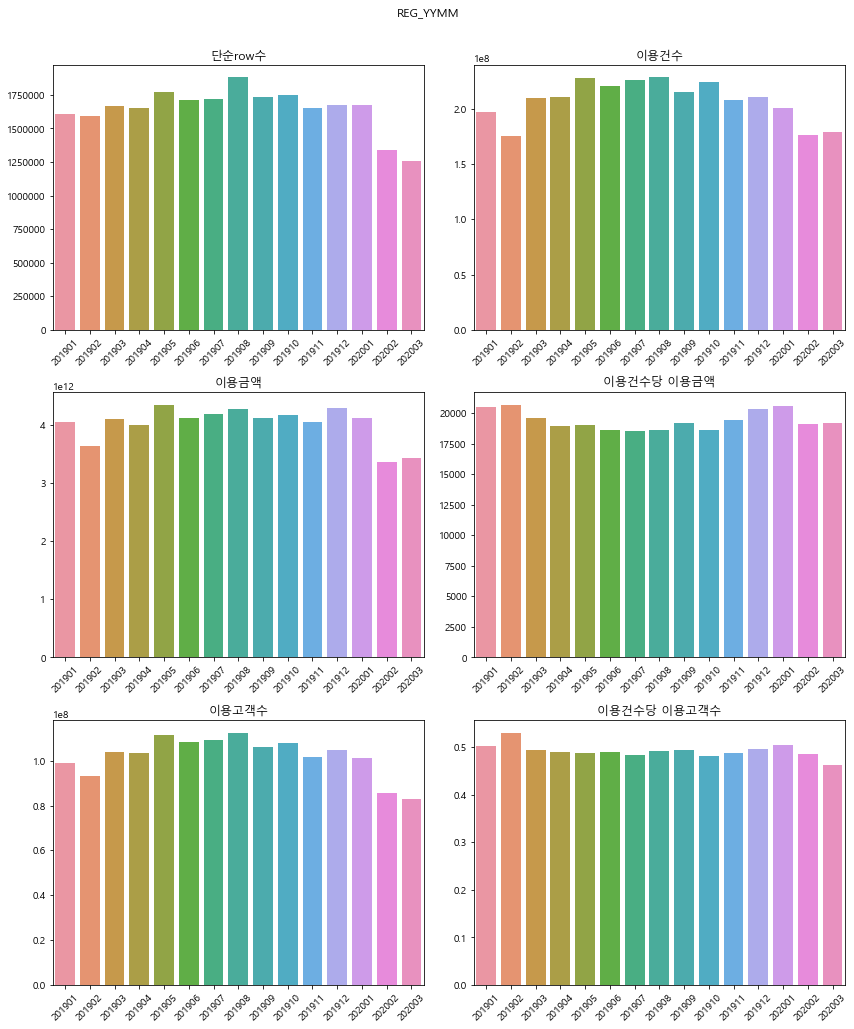

In [124]:
# 날짜
# 겨울(12,1,2)에 이용건수가 다소 감소
# 반면 이용금액 및 건당 이용금액은 더 높은편
draw_eda_graph("REG_YYMM")

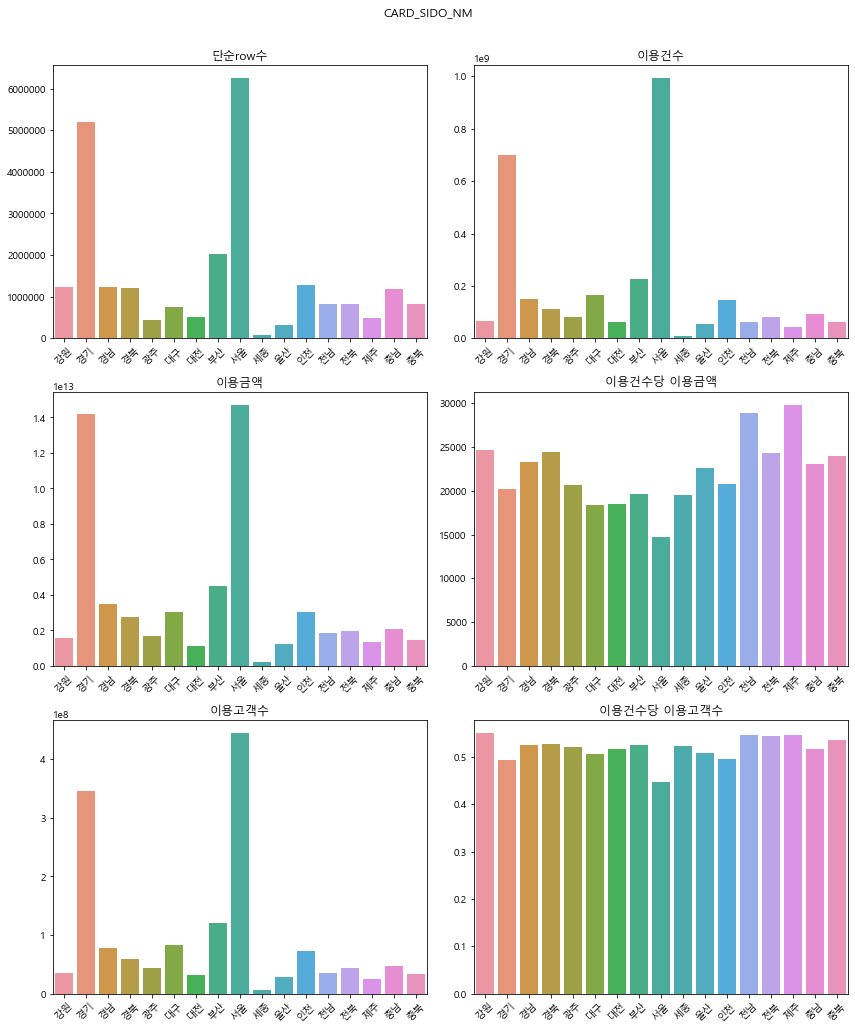

In [122]:
# 카드 이용지역시도 
# 경기서울은 이용건수대비 금액이 높은 편이 아님
# 반면 제주, 전남은 높은것으로 보아 수도권밖 여행지로 추정되는 곳의 건당 금액이 높은 것을 확인
# 서울의 경우 이용건수당 이용금액이 낮은데 환불의 경우가 꽤 있는 것으로 추정
draw_eda_graph("CARD_SIDO_NM")

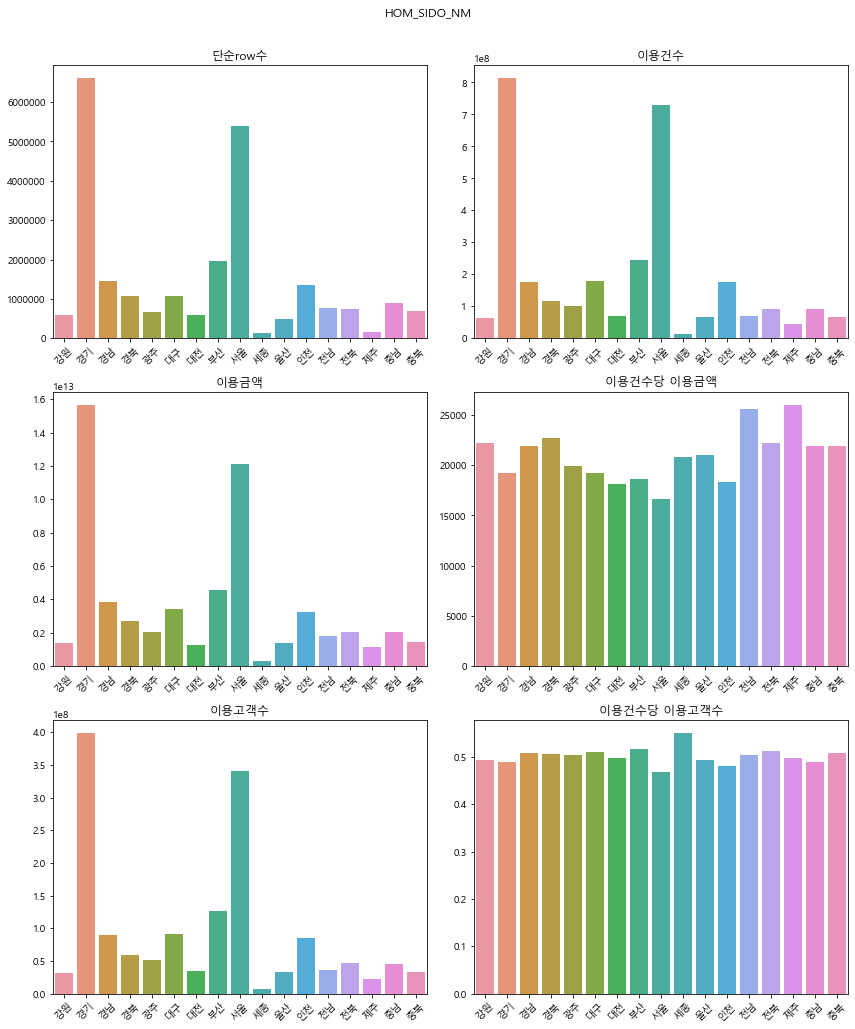

In [128]:
# 거주지역 시도
# 격기지역의 건수가 서울보다 높음
# 이용건수당 이용금액은 카드이용지역대비 전체적으로 낮은 것으로보아 거주지역외에서 이용금액이 다소 높은 것으로 추정
# 거주지역에 따른 이용건수는 큰 차이를 보이지 않음
draw_eda_graph("HOM_SIDO_NM")

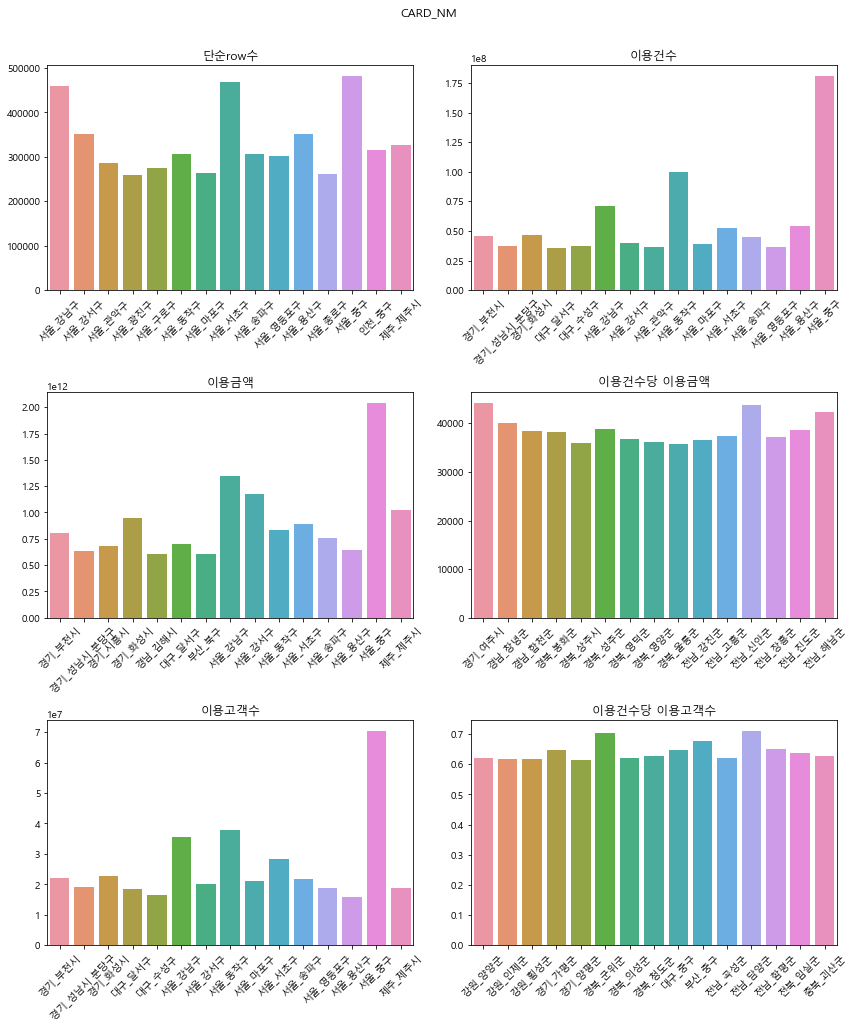

In [135]:
# 카드 이용지역 시군구
# 경기, 대구, 서울의 이용건수가 높으며 서울_중구는 압도적 
# 반면 건당 금액, 이용금액은 수도권밖아 높은편 
train['CARD_NM'] = train.CARD_SIDO_NM + "_" + train.CARD_CCG_NM
draw_eda_graph("CARD_NM",13)

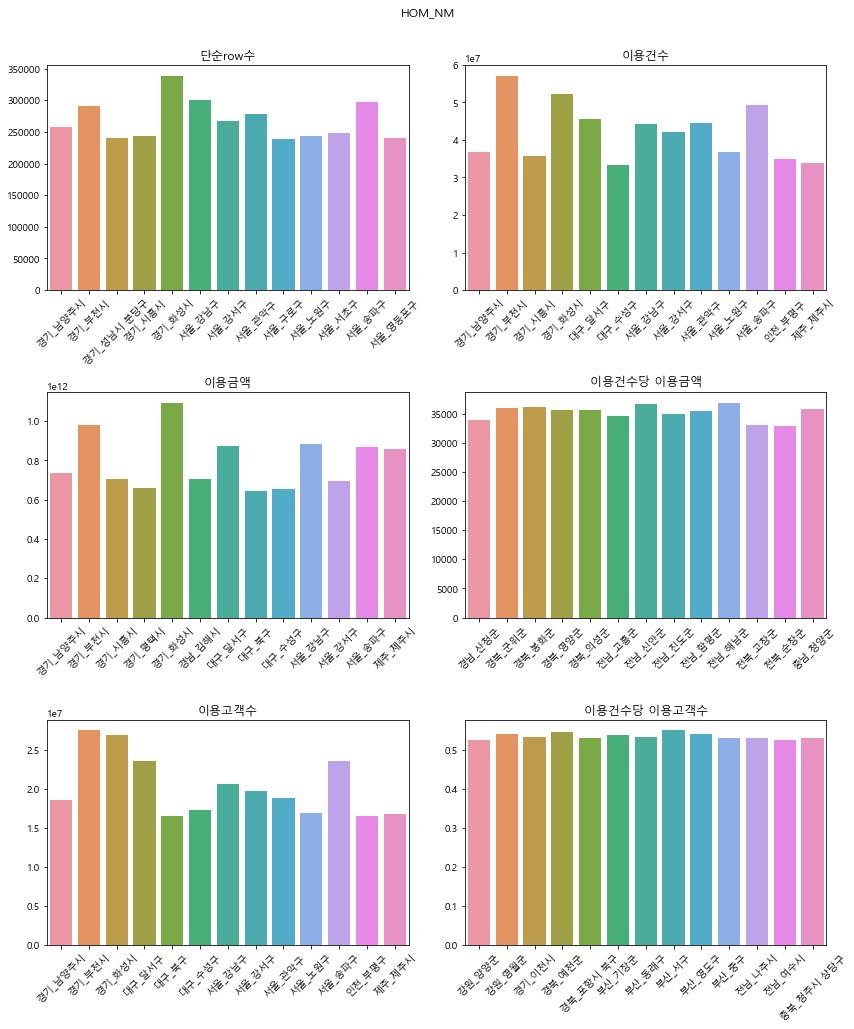

In [137]:
# 거주지역 시군구 
# 카드이용대비 중구가 크게 감소한 것으로 보아 중구의 대부분의 소비는 외지인에 의해 발생함
#
train['HOM_NM'] = train.HOM_SIDO_NM + "_" + train.HOM_CCG_NM
draw_eda_graph("HOM_NM",13)

In [13]:
#인코딩 
train, encoders = encoding(train,"STD_CLSS_NM")
job_name = encoders['STD_CLSS_NM'].inverse_transform(train.STD_CLSS_NM.unique())

job_dict = {}
for i in range(len(job_name)):
    job_dict[i]= job_name[i]

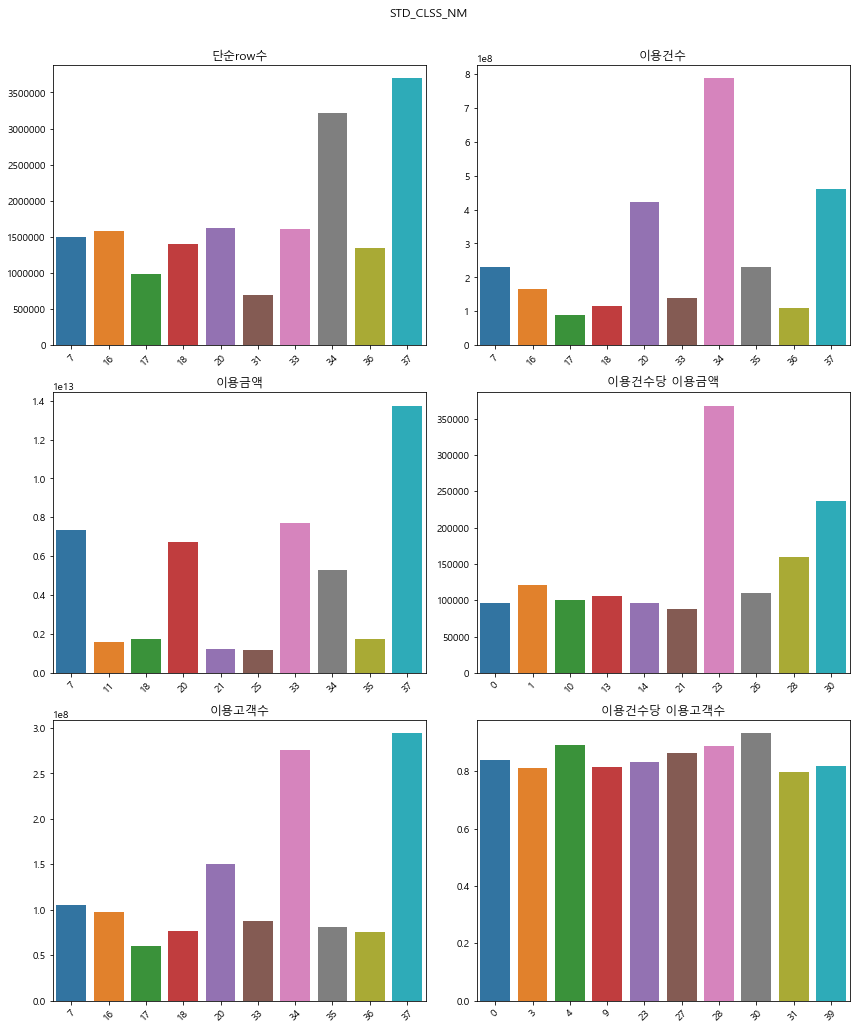

In [27]:
# 34 :면세점, 37, 기타수상오락서비스업의 건수가 높은편, 20 - 일반 유흥 주점업 또 높음 
# 건당 비용은 23 : 중식 음식점이 높고 30- 화장품 및 방향제 소매업이 높음
#
draw_eda_graph("STD_CLSS_NM",10)

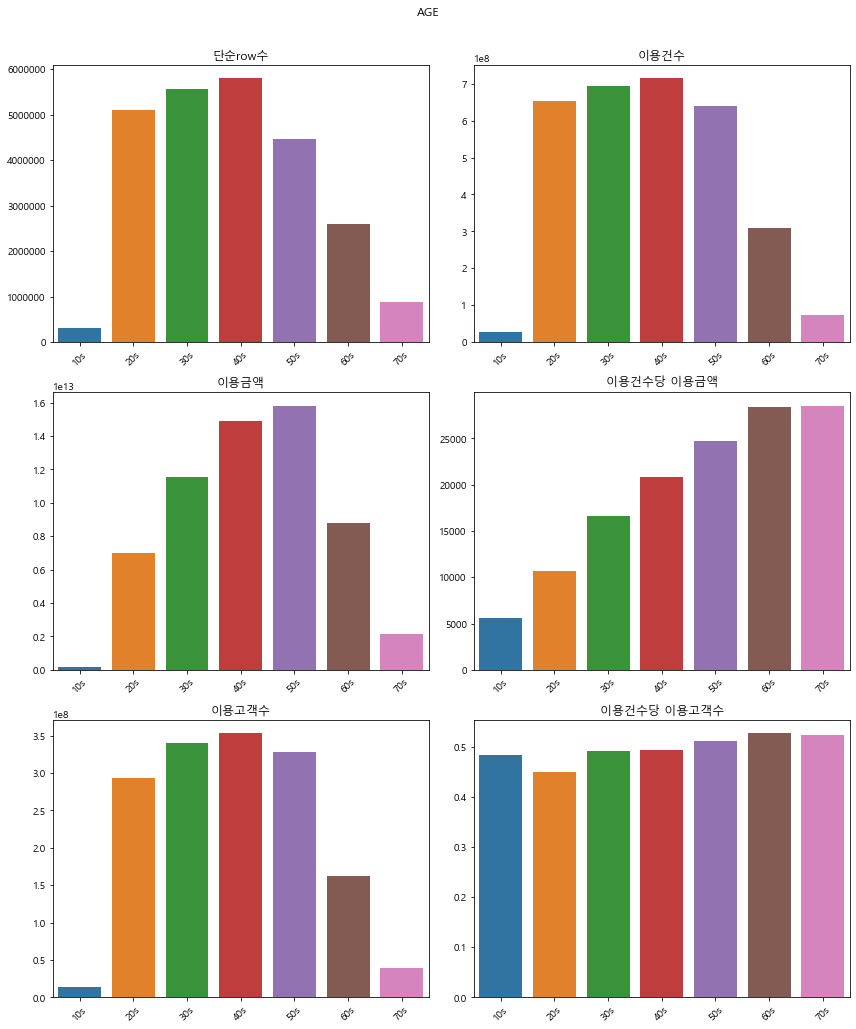

In [139]:
# 연령대 
# 20~50대의 이용건수가 높음
# 이용건수당 이용금액은 연령이 높아질수록 증가
# 20대의 이용건수당 이용금액이 다소 낮음
draw_eda_graph("AGE")

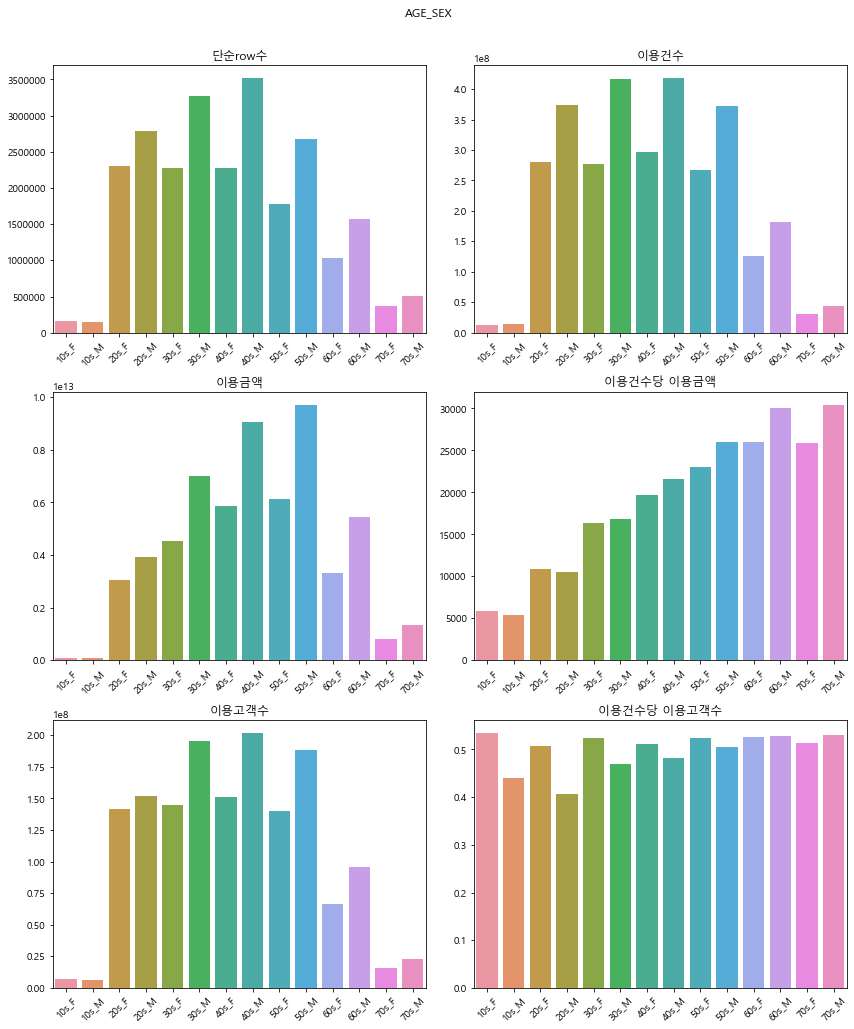

In [148]:
# 나이대_성별 
# 남성의 이용건수가 대체적으로 높음
# 10대 남성의 건당 고객수는 다소 낮은편
sex = train.SEX_CTGO_CD.apply(lambda x : "M" if x == 1  else "F")
train['AGE_SEX'] = train.AGE +'_'+ sex
draw_eda_graph('AGE_SEX',15)

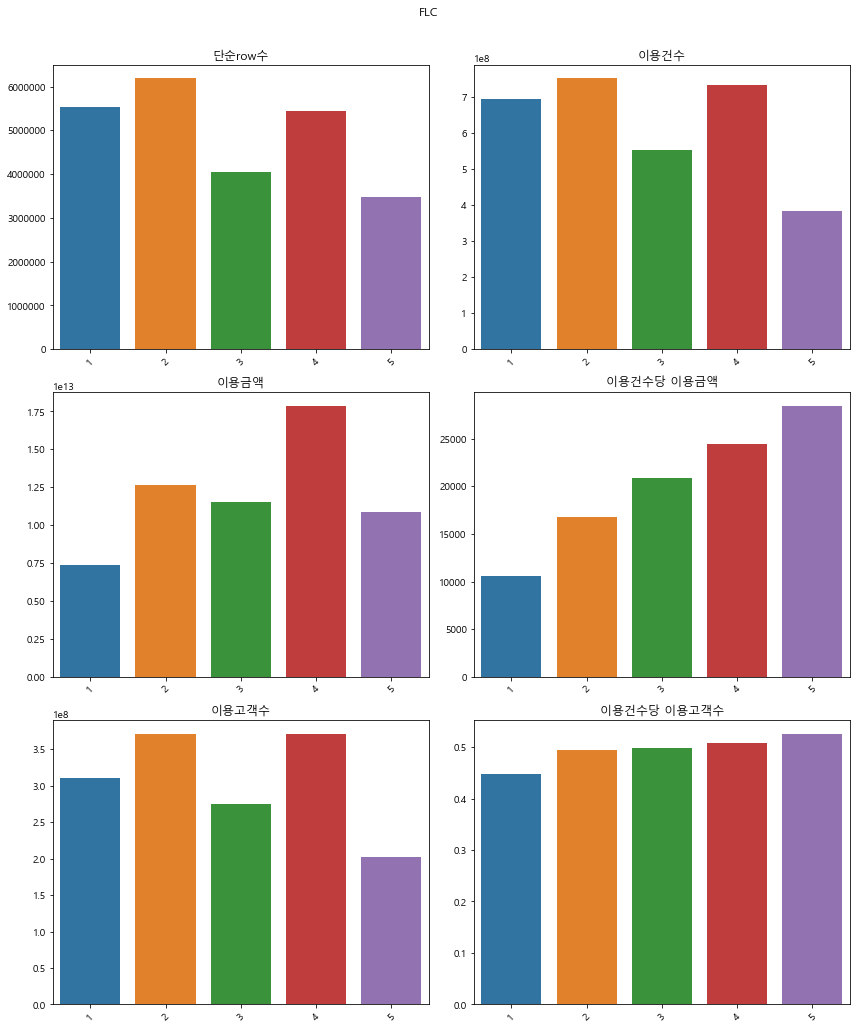

In [149]:
#가구생애주기
# 2,4번 그룹의 이용건수가 높고
# 가구생애주기가 길어질수록 건당 금액이 높음
draw_eda_graph('FLC',15)

### 보다 심화 EDA
* 20년 2-3월은 코로나가 실질적으로 시작한 기간 
 전년대비 차이는 어떻게 되는지 확인해봐야함
* 계절별 차이가 있는가 확인
 